In [1]:
# Import the required libraries
import torch
import torchvision.datasets as datasets
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split
import torch.utils.data
from torchvision import transforms
from torchvision.utils import save_image
from torch.nn.functional import interpolate
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
from PIL import Image

import math
import numpy as np
import pandas as pd

import os
from natsort import natsorted
import random
import pickle
from tqdm import tqdm

In [2]:
# Code to upload dataset to google colab
try:
    from google.colab import drive
    drive.mount('/content/drive')

    import zipfile

    path_to_zip_file = 'drive/MyDrive/data.zip'
    directory_to_extract_to = 'VISCHEMA_PLUS/'
    with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
        zip_ref.extractall(directory_to_extract_to)

    !cp "drive/MyDrive/viscplus_train.csv" "VISCHEMA_PLUS/"
    !cp "drive/MyDrive/viscplus_val.csv" "VISCHEMA_PLUS/"
except:
    print("not in colab")

not in colab


In [3]:
train_csv = pd.read_csv(f"VISCHEMA_PLUS/viscplus_train.csv", header = None)
print(len(train_csv))

print(len(train_csv[0:10]))
print(train_csv[0].values.tolist()[0:10])

1280
10
['sun_bqhdmnfpgbhtjemq.jpg', 'sun_brvopxqzbbmiggcc.jpg', 'sun_bykwtyvknquxsqzc.jpg', 'sun_bywhnbwhctljokav.jpg', 'sun_bcyqhmsuncrhyodx.jpg', 'sun_bglqunwuycxydmyu.jpg', 'sun_bjqxowluzxgdvssb.jpg', 'sun_brfossphjulspavp.jpg', 'sun_bmoouvnnsnxypsla.jpg', 'sun_brrpdracygynlgwk.jpg']


In [4]:
# Create datasets and dataloaders
class VISCHEMA_PLUS(Dataset):
    def __init__(self, dataset_dir = 'VISCHEMA_PLUS/', image_dir = 'images/', label_dir = 'vms/', train = True, transform = None, limit_length=False):
        
        if train:
            train_csv = pd.read_csv(f"{dataset_dir}viscplus_train.csv", header = None)
            if limit_length:
              all_images = train_csv[0].values.tolist()[0:10]
            else:
              all_images = train_csv[0].values.tolist()
        else:
            val_csv = pd.read_csv(f"{dataset_dir}viscplus_val.csv" , header = None)
            if limit_length:
              all_images = val_csv[0].values.tolist()[0:10]
            else:
              all_images = val_csv[0].values.tolist()
            
        self.transform = transform
        
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.dataset_dir = dataset_dir
        
        self.all_images = natsorted(all_images)
        
    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, idx):    
        convert_tensor = transforms.ToTensor()
        
        image = Image.open(f"{self.dataset_dir}{self.image_dir}{self.all_images[idx]}").convert("RGB")
        image = convert_tensor(image)

        label = Image.open(f"{self.dataset_dir}{self.label_dir}{self.all_images[idx]}").convert("RGB")
        label = convert_tensor(label)
        
        if self.transform != None:
            image = self.transform(image)
            label = self.transform(label)
            
        return image, label

batch_size = 1
limit_length = 0
image_size = 64

image_transforms = transforms.Compose([
    transforms.Resize(image_size),
    transforms.Normalize(0.5,0.5)
])

train_dataset = VISCHEMA_PLUS(transform = image_transforms, train=True, limit_length=limit_length)
val_dataset   = VISCHEMA_PLUS(transform = image_transforms, train=False, limit_length=limit_length)

train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle=True)
val_loader   = DataLoader(dataset = val_dataset,   batch_size = batch_size, shuffle=True)

print(f'{len(train_dataset)} Items in Train dataset')
print(f'{len(val_dataset)}  Items in Validation dataset')

1280 Items in Train dataset
320  Items in Validation dataset


c:\Users\bluep\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


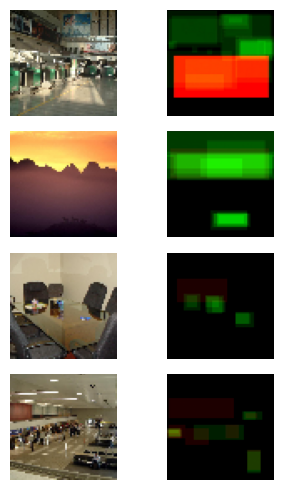

In [5]:
# Examine some image label pairs
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(5,5))
cols, rows = 3, 4
for i in range(rows):
    
    images, labels = next(iter(train_loader))
    
    # The image
    figure.add_subplot(rows,cols, cols*i+1)
    plt.axis("off")
    plt.imshow((images[0].squeeze().permute(1, 2, 0) +1 )/2 )
    
    # The Label
    figure.add_subplot(rows,cols, cols*i+2)
    plt.axis("off")
    plt.imshow((labels[0].squeeze().permute(1, 2, 0) +1 )/2)
    
plt.tight_layout()
plt.show()

In [6]:
class Diffusion:
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=32, scheduler="cosine"):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        if scheduler == "cosine":
            self.beta = self.prepare_noise_schedule().to(self.device)
        else:
            self.beta = self.prepare_cosine_schedule().to(self.device)

        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0)

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def prepare_cosine_schedule(self):
        # This schedule function is by Chen, On the Importance of Noise Scheduling for Diffusion Models
        start = 0
        end = self.noise_steps
        tau = 1
        clip_min = 1e-9
        schedule = []
        for t in range(self.noise_steps):
            v_start = math.cos(start * math.pi / 2) ** ( 2 * tau)
            v_end = math.cos(end * math.pi / 2) ** (2 * tau)
            output = math.cos((t * (end - start) + start) * math.pi / 2) ** (2 * tau)
            output = (v_end - output) / (v_end - v_start)
            schedule += np.clip(output, clip_min, 1)
        return torch.tensor(schedule)

    def noise_images(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]
        Ɛ = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,))

    def sample(self, model, n):
        model.eval()
        with torch.no_grad():
            images, labels = next(iter(val_loader))
            images, labels = images[0:n].to(self.device), labels[0:n].to(self.device)
            x = torch.randn((n, 3, self.img_size, self.img_size)).to(self.device)

            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = (torch.ones(n) * i).long().to(self.device)
                predicted_noise = model(torch.cat((images,x),1), t)
                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(images)
                else:
                    noise = torch.zeros_like(images)
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        
        model.train()
        x = (x.clamp(-1, 1) + 1) / 2
        x = (x * 255).type(torch.uint8)
        return torch.cat([(images+1)/2, (labels+1)/2, x], dim=0)
    
    def test_across_validation(self, model, run_name):
        total_loss = 0
        loss_func  = nn.L1Loss()
        
        model.eval()
        with torch.no_grad():

            # Loop through every image in our validation set
            pbar = tqdm(val_loader)
            for i, (images, labels) in enumerate(pbar):
                
                # Create a batch of images, a batch of labels, and a batch of noise
                images, labels = images.to(self.device), labels.to(self.device)
                x = torch.randn((batch_size, 3, self.img_size, self.img_size)).to(self.device)

                # noise_steps amount of noise removal
                for j in tqdm(reversed(range(1, self.noise_steps)), position=0):
                    t = (torch.ones(batch_size) * j).long().to(self.device)

                    # Given the current state of noise and the timestep, what does the model think is the next state of noise
                    predicted_noise = model(torch.cat((images,x),1), t)
                    alpha = self.alpha[t][:, None, None, None]
                    alpha_hat = self.alpha_hat[t][:, None, None, None]
                    beta = self.beta[t][:, None, None, None]
                    if j > 1:
                        noise = torch.randn_like(images)
                    else:
                        noise = torch.zeros_like(images)

                    # Remove the noise that the model thinks is present from the noise
                    x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
                
                # Transform the output into an image
                x = (x.clamp(-1, 1) + 1) / 2
                x = (x * 255).type(torch.uint8)
                
                # Save images to disk
                save_images(torch.cat([(images+1)/2, (labels+1)/2, x], dim=0),f'saved_images/{run_name}',f"/{i}.png")

                # Compute the loss
                total_loss += loss_func(x, labels).item() * batch_size
        
        total_loss /= len(val_dataset)
        return total_loss

In [7]:
# UNET
class SelfAttention(nn.Module):
    def __init__(self, channels):
        super(SelfAttention, self).__init__()
        self.channels = channels        
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        size = x.shape[-1]
        x = x.view(-1, self.channels, size * size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, size, size)

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, t):
        try:
            x2 = self.maxpool_conv(x)
            emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x2.shape[-2], x2.shape[-1])
            return x2 + emb
        except:
            print(x.size())
            x = self.maxpool_conv(x)
            print(x.size())
            emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
            print(emb.size())
            return x + emb

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class UNet(nn.Module):
    def __init__(self, c_in=6, c_out=3, time_dim=256, remove_deep_conv=False):
        super().__init__()
        self.time_dim = time_dim
        self.remove_deep_conv = remove_deep_conv
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.sa1 = SelfAttention(128)
        self.down2 = Down(128, 256)
        self.sa2 = SelfAttention(256)
        self.down3 = Down(256, 512)
        self.sa3 = SelfAttention(512)

        self.bot1 = DoubleConv(512, 1024)
        self.bot2 = DoubleConv(1024, 1024)
        self.bot3 = DoubleConv(1024, 512)

        self.up1 = Up(768, 256)
        self.sa4 = SelfAttention(256)
        self.up2 = Up(384, 128)
        self.sa5 = SelfAttention(128)
        self.up3 = Up(192, 64)
        self.sa6 = SelfAttention(64)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)

    def pos_encoding(self, t, channels):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device = device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def unet_forwad(self, x, t):
        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)

        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)

        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.outc(x)
        return output
    
    def forward(self, x, t):
        t = t.unsqueeze(-1)
        t = self.pos_encoding(t, self.time_dim)
        return self.unet_forwad(x, t)

In [8]:
def save_images(images, path, image_name = ""):

    exists = os.path.exists(path)
    if not exists:
        os.makedirs(path)

    grid = torchvision.utils.make_grid(images, nrow = batch_size)
    save_image(grid, path+image_name)

In [9]:
def train(run_name, diffusion):
    # Saved images and model directories
    for path in [f"models/{run_name}", f"results/{run_name}", f"train_losses/{run_name}", f"val_losses/{run_name}"]:
        exists = os.path.exists(path)
        if not exists:
            os.makedirs(path)

    # Set up our training environment
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = UNet().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
    mse = nn.MSELoss()
    l = len(train_loader)

    train_losses = []
    val_losses = []

    num_epochs = 600
    
    for epoch in range(num_epochs):
        total_train_loss = 0
        total_val_loss = 0
        print(f"Epoch: {epoch}")
        
        # Train Generator
        model.train()
        pbar = tqdm(train_loader)
        for i, (images, labels) in enumerate(pbar):
            images, labels = images.to(device), labels.to(device)    

            t = diffusion.sample_timesteps(labels.shape[0]).to(device)
            x_t, noise = diffusion.noise_images(labels, t)
            predicted_noise = model(torch.cat((images, x_t), 1), t)
            loss = mse(noise, predicted_noise)
            total_train_loss += loss.item() * batch_size

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item() * batch_size
            pbar.set_postfix(Train_Loss = total_train_loss)
            
        # Clear memory
        del images, labels
        torch.cuda.empty_cache() 

        # Validate Generator
        model.eval()
        with torch.no_grad():
            pbar = tqdm(val_loader)
            for i, (images, labels) in enumerate(pbar):

                images,labels = images.to(device), labels.to(device)
                
                t = diffusion.sample_timesteps(labels.shape[0]).to(device)
                x_t, noise = diffusion.noise_images(labels, t)
                predicted_noise = model(torch.cat((images, x_t), 1), t)
                loss = mse(noise, predicted_noise)
                total_val_loss += loss.item() * batch_size

                pbar.set_postfix(Val_loss = total_val_loss)

        # Save losses
        train_losses.append(total_train_loss/ len(train_loader))
        val_losses.append(total_val_loss / len(val_loader))

        # Save sample images every 20 epochs
        if epoch % 20 == 0:
            sampled_images = diffusion.sample(model, n=batch_size)
            print(sampled_images.size())
            save_images(sampled_images, f"results/{run_name}/{epoch}.jpg")
            torch.save(model.state_dict(), f"models/{run_name}/{epoch}.pt")

        # Clear memory
        del images, labels 
        torch.cuda.empty_cache()

    print(diffusion.test_across_validation(model, run_name))
    with open(os.path.join("train_losses",f"{run_name}.pkl"), 'wb') as f:
        pickle.dump(train_losses, f)
    with open(os.path.join("val_losses",f"{run_name}.pkl"), 'wb') as f:
        pickle.dump(val_losses, f)

In [10]:
# Cosine_2000
run_name = "cosine2000"
diffusion = Diffusion(img_size = image_size, noise_steps=2000)
train(run_name, diffusion)

Epoch: 0


 72%|███████▏  | 920/1280 [01:12<00:27, 13.10it/s, Train_Loss=97.3]

In [33]:
# Cosine_500
run_name = "cosine1000"

diffusion = Diffusion(img_size = image_size, noise_steps=1000)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
model.load_state_dict(torch.load(f"models/{run_name}/200.pt"))
total_loss = diffusion.test_across_validation(model, run_name)
print(total_loss)

999it [00:33, 29.45it/s]0:00<?, ?it/s]
183it [00:06, 28.54it/s]0:34<44:49, 34.04s/it]
  1%|▏         | 1/80 [00:40<53:21, 40.53s/it]


KeyboardInterrupt: 

In [ ]:
# Cosine_250
run_name = "cosine250"
diffusion = Diffusion(img_size = image_size, noise_steps=250)
train(run_name, diffusion)

In [ ]:
"""device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
diffusion = Diffusion(img_size = image_size)
total_loss = diffusion.test_across_validation(model)
print(total_loss)"""

40it [00:57,  1.43s/it]00:00<?, ?it/s]
  0%|          | 0/80 [00:57<?, ?it/s]


KeyboardInterrupt: 